#  1. Classic PointNet

### (a) Download and Import

In [145]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import math
import random
import os
import torch
import meshio
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

from pointNet import pointNet as pointNet
from pointNet import model as model
from utils import Mesh as M
from pointNet import model as pm

In [2]:
!pip install path.py;
from path import Path

In [3]:
random.seed = 82

In [67]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2021-02-27 14:44:36--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
正在解析主机 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.61
正在连接 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.61|:80... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：473402300 (451M) [application/zip]
正在保存至: “ModelNet10.zip”

ModelNet10.zip      100%[===================>] 451.47M   853KB/s  用时 7m 37s    

2021-02-27 14:52:13 (1011 KB/s) - 已保存 “ModelNet10.zip” [473402300/473402300])



In [68]:
!unzip -q ModelNet10.zip

In [3]:
path = Path("ModelNet10")

In [4]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

Import and visualize the bed:

In [5]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [143]:
fpath = path + "/toilet/train/toilet_0001.off"
toilet = M.Mesh(fpath)

In [139]:
fpath = path + "/bed/train/bed_0001.off"
bed = M.Mesh(fpath)

with open(path/"bed/train/bed_0001.off", 'r') as f:
    verts, faces = read_off(f)

i,j,k = np.array(bed.f).T
x,y,z = np.array(bed.v).T

len(x)

2095

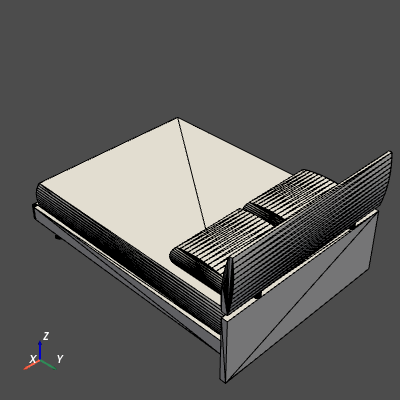

PolyData,Information
N Cells,1807
N Points,2095
X Bounds,"1.426e+02, 2.061e+02"
Y Bounds,"-8.762e+01, -2.564e+00"
Z Bounds,"0.000e+00, 4.200e+01"
N Arrays,0


In [16]:
bed.render_wireframe(notebook=True, show_faces=True, window_size=[400, 400])

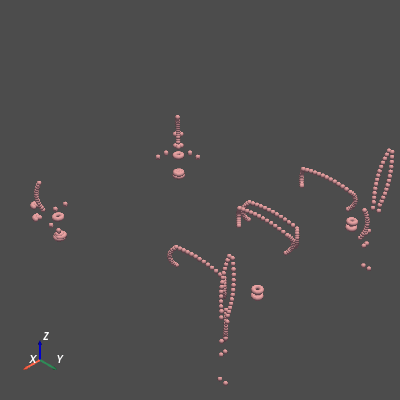

PolyData,Information
N Cells,2095
N Points,2095
X Bounds,"1.426e+02, 2.061e+02"
Y Bounds,"-8.762e+01, -2.564e+00"
Z Bounds,"0.000e+00, 4.200e+01"
N Arrays,0


In [21]:
bed.render_pointcloud(color='lightpink', notebook=True, window_size=[400, 400])

- From the pointcloud we can see that the points are **not uniformly distributed** across object's surface, so it could be difficult for the PointNet to classify them. 
- In order to make the pointclouds look more like to their real shapes, we need to **uniformly sample** the points on the object's surface.

### (b) Transforms

#### Sample points

In [86]:
pointcloud = pointNet.PointSampler(5000)((bed.v, bed.f))

In [33]:
print("pointcloud: \n", pointcloud)

pointcloud: 
 [[172.58776236 -64.21738553  21.75      ]
 [145.38       -46.30944929  13.39150936]
 [203.02019881 -69.42794858  11.75      ]
 ...
 [162.45058221 -62.58279648  11.75      ]
 [201.26590613  -6.12211324  16.83545706]
 [175.3175637  -41.23449745  21.75      ]]


#### Normalize

In [27]:
norm_pointcloud = pointNet.Normalize()(pointcloud)

In [34]:
print("normalized pointcloud: \n", norm_pointcloud)

normalized pointcloud: 
 [[-0.02392835 -0.49190496  0.04546557]
 [-0.45533785 -0.20795461 -0.08706765]
 [ 0.45861196 -0.57452426 -0.11309561]
 ...
 [-0.18466468 -0.46598672 -0.11309561]
 [ 0.43079569  0.42926055 -0.03246001]
 [ 0.0193557  -0.12748557  0.04546557]]


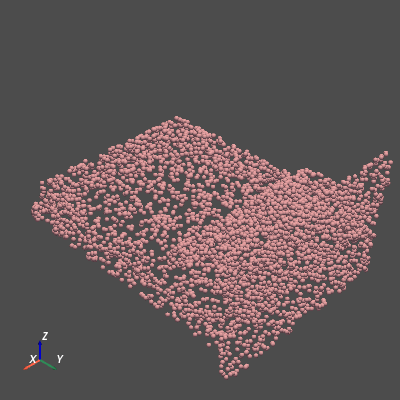

PolyData,Information
N Cells,5000
N Points,5000
X Bounds,"-4.989e-01, 5.079e-01"
Y Bounds,"-8.630e-01, 4.857e-01"
Z Bounds,"-2.994e-01, 3.666e-01"
N Arrays,0


In [36]:
bed.render_pointcloud(vertex=norm_pointcloud, color='lightpink', notebook=True, window_size=[400, 400])

#### Augmentation

Add *random rotation* and *random noise* to the pointcloud

In [39]:
rot_pointcloud = pointNet.RandRotation()(norm_pointcloud)
noisy_rot_pointcloud = pointNet.RandomNoise()(rot_pointcloud)

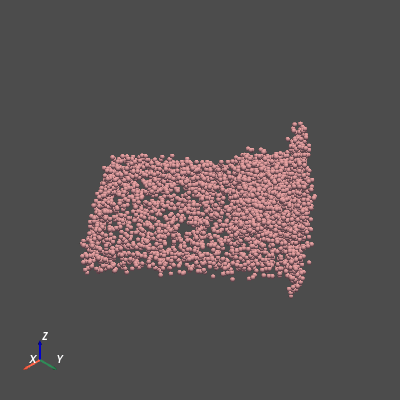

PolyData,Information
N Cells,5000
N Points,5000
X Bounds,"-7.310e-01, 9.611e-01"
Y Bounds,"-1.017e+00, 7.365e-01"
Z Bounds,"-3.371e-01, 4.047e-01"
N Arrays,0


In [42]:
bed.render_pointcloud(vertex=noisy_rot_pointcloud, color='lightpink', notebook=True, window_size=[400, 400])

#### ToTensor

In [43]:
pointNet.ToTensor()(noisy_rot_pointcloud)

tensor([[ 0.2890, -0.3912,  0.0842],
        [-0.2239, -0.4630, -0.0857],
        [ 0.6952, -0.1433, -0.1327],
        ...,
        [ 0.1513, -0.4926, -0.1082],
        [ 0.0485,  0.6206, -0.0074],
        [ 0.1080, -0.0845,  0.0742]], dtype=torch.float64)

### (c) Dataset

In [6]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=pointNet.default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else pointNet.default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [7]:
train_ds = PointCloudData(path, transform=pointNet.train_transforms())
valid_ds = PointCloudData(path, valid=True, folder='test', transform=pointNet.train_transforms())

In [8]:
inv_classes = {i: item for item, i in train_ds.classes.items()};

In [9]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [9]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

### (d) PointNet Training loop

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [117]:
pointnet = model.PointNet()
pointnet.to(device);

In [79]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [87]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2), channel="pointnet")

            loss = pointNet.pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        pointnet_valid_acc_list = []
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2), channel="pointnet")
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)
            pointnet_valid_acc_list.append((epoch, val_acc))

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "SavedPath/PointNet_Path10/classic/save_"+str(epoch)+".pth")

In [88]:
%%time
train(pointnet, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /  125], loss: 1.246
[Epoch: 1, Batch:   20 /  125], loss: 1.211
[Epoch: 1, Batch:   30 /  125], loss: 1.139
[Epoch: 1, Batch:   40 /  125], loss: 1.143
[Epoch: 1, Batch:   50 /  125], loss: 1.137
[Epoch: 1, Batch:   60 /  125], loss: 1.030
[Epoch: 1, Batch:   70 /  125], loss: 1.070
[Epoch: 1, Batch:   80 /  125], loss: 0.968
[Epoch: 1, Batch:   90 /  125], loss: 0.865
[Epoch: 1, Batch:  100 /  125], loss: 0.892
[Epoch: 1, Batch:  110 /  125], loss: 0.859
[Epoch: 1, Batch:  120 /  125], loss: 0.835
Valid accuracy: 68 %
[Epoch: 2, Batch:   10 /  125], loss: 0.855
[Epoch: 2, Batch:   20 /  125], loss: 0.843
[Epoch: 2, Batch:   30 /  125], loss: 0.824
[Epoch: 2, Batch:   40 /  125], loss: 0.856
[Epoch: 2, Batch:   50 /  125], loss: 0.801
[Epoch: 2, Batch:   60 /  125], loss: 0.717
[Epoch: 2, Batch:   70 /  125], loss: 0.750
[Epoch: 2, Batch:   80 /  125], loss: 0.880
[Epoch: 2, Batch:   90 /  125], loss: 0.812
[Epoch: 2, Batch:  100 /  125], loss: 0.693
[Epoch: 2, 

### (e) PointNet Test

In [41]:
from sklearn.metrics import confusion_matrix

In [90]:
epochs = 15
pointnet = model.PointNet()
for epoch in range(epochs):
    pointnet.load_state_dict(torch.load('SavedPath/PointNet_Path10/classic/save_'+str(epoch)+".pth"))
pointnet.eval();

In [91]:
%%time
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2), channel="pointnet")
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]
CPU times: user 3min 17s, sys: 13.9 s, total: 3min 31s
Wall time: 3min 5s


In [92]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[ 40,   6,   0,   0,   0,   0,   0,   3,   0,   1],
       [  1,  87,   0,   0,   0,   0,   0,  12,   0,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   4,  59,   0,   5,   1,   8,   9,   0],
       [  0,   0,   0,   0,  72,   5,   6,   1,   1,   1],
       [  0,   0,   1,   0,   1,  98,   0,   0,   0,   0],
       [  0,   0,   0,   2,  28,   0,  51,   1,   3,   1],
       [  0,   0,   0,   0,   0,   1,   1,  97,   0,   1],
       [  0,   0,   0,  13,   0,   0,   0,   0,  87,   0],
       [  0,   1,   5,   1,   0,   5,   0,   1,   0,  87]])

In [93]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


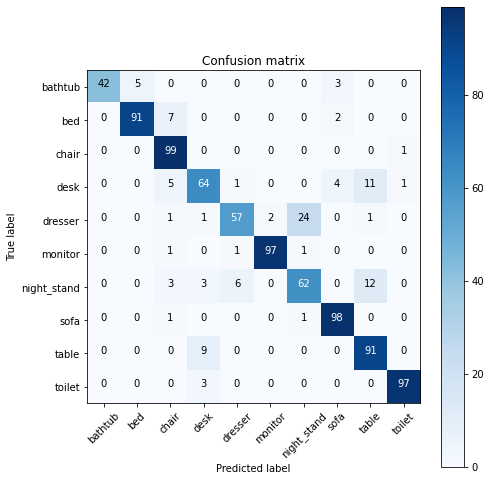

In [164]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

Normalized confusion matrix


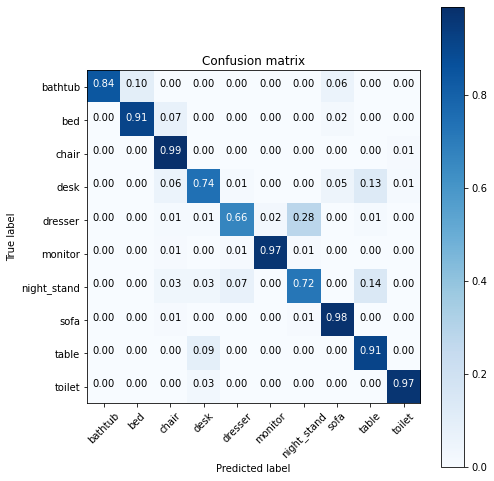

In [165]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

# 2. First and Second Order Momenets

## (a) 1 and 2 order Training loop

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [28]:
momenet = model.Momenet()
momenet.to(device);

In [29]:
optimizer = torch.optim.Adam(momenet.parameters(), lr=0.001)

In [47]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    momenet2_valid_acc_list = []
    for epoch in range(epochs): 
        momenet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            # inputs.shape == (B, N, C_in) -> [32, 1024, 3]
            outputs, m3x3= momenet(inputs, channel="second")

            loss = pointNet.momenetloss(outputs, labels, m3x3)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' % (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        momenet.eval()
        correct = total = 0

        # validation
        
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __= momenet(inputs, channel="second")
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)
            momenet2_valid_acc_list.append((epoch, val_acc))

        # save the model
        if save:
            torch.save(momenet.state_dict(), "SavedPath/Momenet_Path10/Second/save_"+str(epoch)+".pth")

In [48]:
%%time
train(momenet, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /  125], loss: 0.743
[Epoch: 1, Batch:   20 /  125], loss: 0.676
[Epoch: 1, Batch:   30 /  125], loss: 0.754
[Epoch: 1, Batch:   40 /  125], loss: 0.483
[Epoch: 1, Batch:   50 /  125], loss: 0.700
[Epoch: 1, Batch:   60 /  125], loss: 0.638
[Epoch: 1, Batch:   70 /  125], loss: 0.633
[Epoch: 1, Batch:   80 /  125], loss: 0.664
[Epoch: 1, Batch:   90 /  125], loss: 0.651
[Epoch: 1, Batch:  100 /  125], loss: 0.612
[Epoch: 1, Batch:  110 /  125], loss: 0.603
[Epoch: 1, Batch:  120 /  125], loss: 0.507
Valid accuracy: 72 %
[Epoch: 2, Batch:   10 /  125], loss: 0.537
[Epoch: 2, Batch:   20 /  125], loss: 0.545
[Epoch: 2, Batch:   30 /  125], loss: 0.690
[Epoch: 2, Batch:   40 /  125], loss: 0.590
[Epoch: 2, Batch:   50 /  125], loss: 0.593
[Epoch: 2, Batch:   60 /  125], loss: 0.716
[Epoch: 2, Batch:   70 /  125], loss: 0.565
[Epoch: 2, Batch:   80 /  125], loss: 0.528
[Epoch: 2, Batch:   90 /  125], loss: 0.481
[Epoch: 2, Batch:  100 /  125], loss: 0.666
[Epoch: 2, 

## (b) 1 and 2 order Test loop

In [56]:
epochs = 15
for epoch in range(epochs):
    momenet.load_state_dict(torch.load('SavedPath/Momenet_Path10/Second/save_'+str(epoch)+".pth"))
momenet.eval();

In [57]:
%%time
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __ = momenet(inputs, channel="second")
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]
CPU times: user 3min 55s, sys: 33.5 s, total: 4min 29s
Wall time: 4min 11s


In [58]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[42,  5,  0,  0,  0,  0,  0,  3,  0,  0],
       [ 0, 91,  7,  0,  0,  0,  0,  2,  0,  0],
       [ 0,  0, 99,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  5, 64,  1,  0,  0,  4, 11,  1],
       [ 0,  0,  1,  1, 57,  2, 24,  0,  1,  0],
       [ 0,  0,  1,  0,  1, 97,  1,  0,  0,  0],
       [ 0,  0,  3,  3,  6,  0, 62,  0, 12,  0],
       [ 0,  0,  1,  0,  0,  0,  1, 98,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0, 91,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0, 97]])

In [43]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


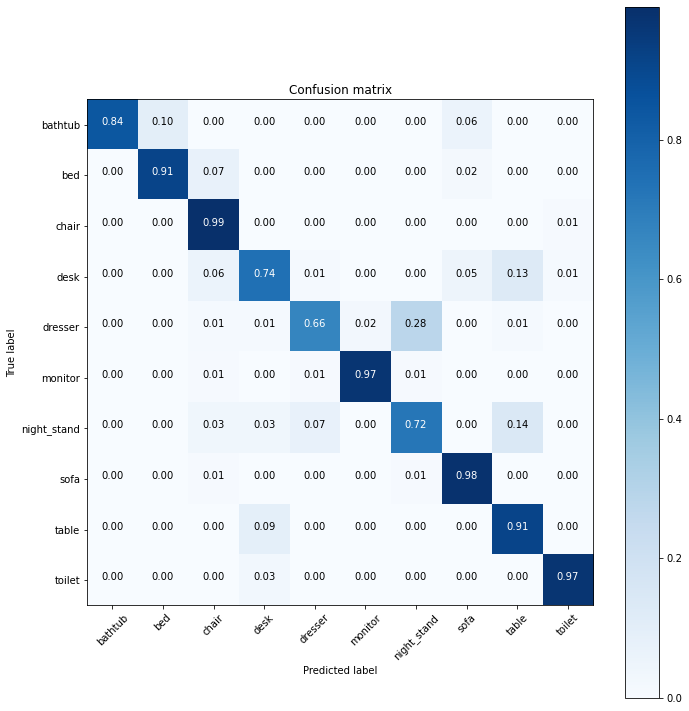

In [59]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Normalized confusion matrix


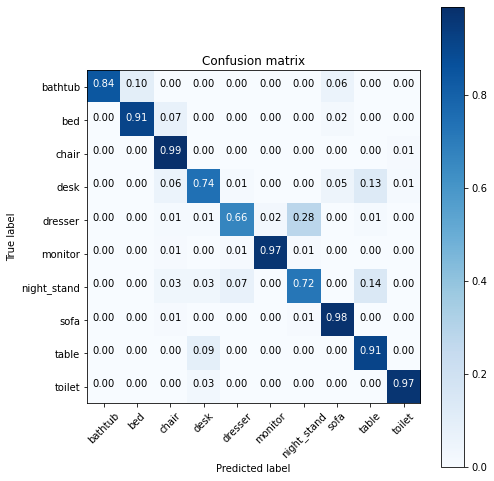

In [167]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

# 3. First, Second and Third Order Momenets

## (a) 1, 2 and 3 order Training loop

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [62]:
momenet3 = model.Momenet()
momenet3.to(device);

In [63]:
optimizer = torch.optim.Adam(momenet3.parameters(), lr=0.001)

In [64]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    momenet3_acc_list = []
    for epoch in range(epochs): 
        momenet3.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            # inputs.shape == [32, 1024, 3]
            outputs, m3x3= momenet3(inputs, channel="third")

            loss = pointNet.momenetloss(outputs, labels, m3x3)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' % (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        momenet3.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __= momenet3(inputs, channel="third")
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)
            momenet3_acc_list.append((epoch, val_acc))

        # save the model
        if save:
            torch.save(momenet3.state_dict(), "SavedPath/Momenet_Path10/Third/save_"+str(epoch)+".pth")

In [65]:
%%time
train(momenet3, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /  125], loss: 2.284
[Epoch: 1, Batch:   20 /  125], loss: 1.937
[Epoch: 1, Batch:   30 /  125], loss: 1.986
[Epoch: 1, Batch:   40 /  125], loss: 1.760
[Epoch: 1, Batch:   50 /  125], loss: 1.798
[Epoch: 1, Batch:   60 /  125], loss: 1.629
[Epoch: 1, Batch:   70 /  125], loss: 1.699
[Epoch: 1, Batch:   80 /  125], loss: 1.515
[Epoch: 1, Batch:   90 /  125], loss: 1.296
[Epoch: 1, Batch:  100 /  125], loss: 1.323
[Epoch: 1, Batch:  110 /  125], loss: 1.262
[Epoch: 1, Batch:  120 /  125], loss: 1.291
Valid accuracy: 51 %
[Epoch: 2, Batch:   10 /  125], loss: 1.171
[Epoch: 2, Batch:   20 /  125], loss: 1.138
[Epoch: 2, Batch:   30 /  125], loss: 1.062
[Epoch: 2, Batch:   40 /  125], loss: 0.978
[Epoch: 2, Batch:   50 /  125], loss: 1.019
[Epoch: 2, Batch:   60 /  125], loss: 0.909
[Epoch: 2, Batch:   70 /  125], loss: 0.917
[Epoch: 2, Batch:   80 /  125], loss: 0.966
[Epoch: 2, Batch:   90 /  125], loss: 0.902
[Epoch: 2, Batch:  100 /  125], loss: 0.866
[Epoch: 2, 

## (b) 1, 2 and 3 order Test loop

In [67]:
epochs = 15
for epoch in range(epochs):
    momenet3.load_state_dict(torch.load('SavedPath/Momenet_Path10/Third/save_'+str(epoch)+".pth"))
momenet3.eval();

In [68]:
%%time
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __ = momenet3(inputs, channel="third")
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]
CPU times: user 4min 3s, sys: 35.8 s, total: 4min 39s
Wall time: 4min 20s


In [69]:
cm3 = confusion_matrix(all_labels, all_preds);
cm3

array([[ 33,  13,   4,   0,   0,   0,   0,   0,   0,   0],
       [  0,  96,   0,   0,   0,   0,   0,   0,   4,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   7,  37,   0,   1,   6,   2,  33,   0],
       [  0,   0,   0,   0,  28,   3,  53,   0,   1,   1],
       [  0,   0,   1,   0,   0,  97,   2,   0,   0,   0],
       [  0,   0,  10,   0,   1,   0,  70,   0,   5,   0],
       [  0,  10,   2,   0,   0,   1,   0,  87,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,  99,   0],
       [  0,   0,  16,   0,   1,   1,   3,   0,   0,  79]])

Normalized confusion matrix


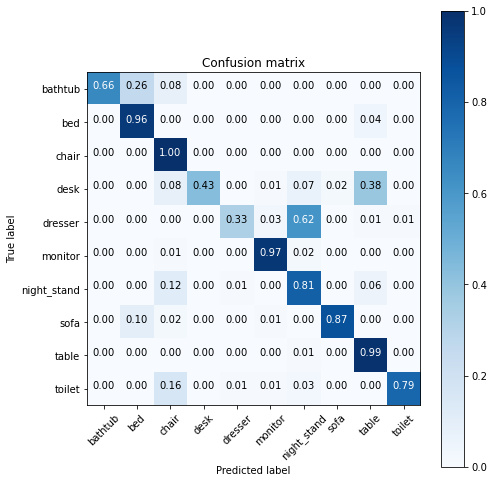

In [168]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm3, list(classes.keys()), normalize=True)

# 4.  Consistently Oriented Vertex Normals

## 4.1 Classic PointNet with Vertex Normals

In [72]:
pointnet_vn = model.PointNet()
pointnet_vn.to(device)
optimizer = torch.optim.Adam(pointnet_vn.parameters(), lr=0.001)

### 4.1 (a) Training

In [80]:
def train(model, train_loader, val_loader=None,  epochs=10, save=True):
    pointnet_vn_acc_list = []
    for epoch in range(epochs): 
        pointnet_vn.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet_vn(inputs.transpose(1,2), channel="vn")

            loss = pointNet.pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet_vn.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet_vn(inputs.transpose(1,2), channel="vn")
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)
            pointnet_vn_acc_list.append((epoch, val_acc))

        # save the model
        if save:
            torch.save(pointnet_vn.state_dict(), "SavedPath/PointNet_Path10/vn/save_"+str(epoch)+".pth")

In [81]:
%%time
train(pointnet_vn, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /  125], loss: 2.002
[Epoch: 1, Batch:   20 /  125], loss: 1.625
[Epoch: 1, Batch:   30 /  125], loss: 1.373
[Epoch: 1, Batch:   40 /  125], loss: 1.287
[Epoch: 1, Batch:   50 /  125], loss: 1.176
[Epoch: 1, Batch:   60 /  125], loss: 1.049
[Epoch: 1, Batch:   70 /  125], loss: 0.884
[Epoch: 1, Batch:   80 /  125], loss: 0.917
[Epoch: 1, Batch:   90 /  125], loss: 0.897
[Epoch: 1, Batch:  100 /  125], loss: 0.946
[Epoch: 1, Batch:  110 /  125], loss: 0.796
[Epoch: 1, Batch:  120 /  125], loss: 0.767
Valid accuracy: 52 %
[Epoch: 2, Batch:   10 /  125], loss: 0.724
[Epoch: 2, Batch:   20 /  125], loss: 0.711
[Epoch: 2, Batch:   30 /  125], loss: 0.726
[Epoch: 2, Batch:   40 /  125], loss: 0.676
[Epoch: 2, Batch:   50 /  125], loss: 0.728
[Epoch: 2, Batch:   60 /  125], loss: 0.718
[Epoch: 2, Batch:   70 /  125], loss: 0.704
[Epoch: 2, Batch:   80 /  125], loss: 0.653
[Epoch: 2, Batch:   90 /  125], loss: 0.720
[Epoch: 2, Batch:  100 /  125], loss: 0.597
[Epoch: 2, 

### 4.1 (b) Test

In [82]:
epochs = 10
for epoch in range(epochs):
    pointnet_vn.load_state_dict(torch.load('SavedPath/Pointnet_Path10/vn/save_'+str(epoch)+".pth"))
pointnet_vn.eval();

In [88]:
%%time
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, _, _ = pointnet_vn(inputs.transpose(1,2), channel="vn")
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]
CPU times: user 3min 30s, sys: 15.2 s, total: 3min 45s
Wall time: 3min 19s


In [90]:
cm_vn = confusion_matrix(all_labels, all_preds);
cm_vn

array([[41,  5,  0,  0,  0,  0,  0,  0,  3,  1],
       [ 1, 87,  0,  2,  0,  0,  0,  0, 10,  0],
       [ 0,  0, 99,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 77,  0,  0,  1,  0,  7,  1],
       [ 0,  0,  0, 11, 62,  7,  1,  0,  1,  4],
       [ 0,  0,  3,  0,  0, 93,  0,  0,  0,  4],
       [ 0,  0,  0, 24, 25,  1, 21,  0, 11,  4],
       [ 0,  1,  0, 19,  0,  1,  0, 73,  0,  6],
       [ 0,  0,  0, 28,  0,  0,  0,  0, 72,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0, 99]])

Normalized confusion matrix


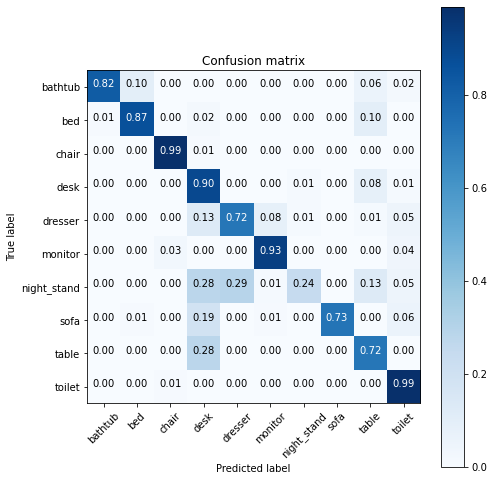

In [171]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_vn, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


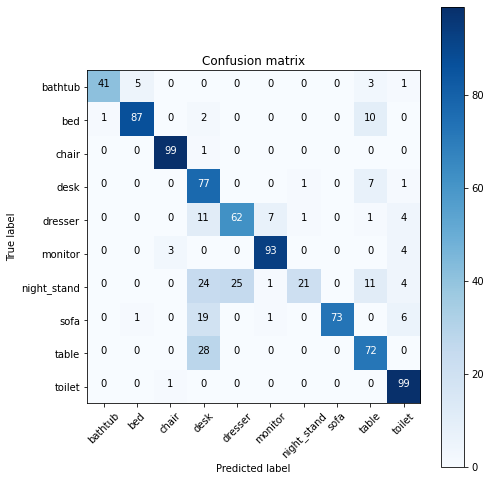

In [172]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_vn, list(classes.keys()), normalize=False)

## 4.2 Classic Momenet with Vertex Normals

In [93]:
momenet_vn2 = model.Momenet()
momenet_vn2.to(device)
optimizer = torch.optim.Adam(momenet_vn2.parameters(), lr=0.001)

### 4.2 (a) Training

In [94]:
def train(model, train_loader, val_loader=None,  epochs=10, save=True):
    momenet_vn2_acc_list = []
    for epoch in range(epochs): 
        momenet_vn2.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            # inputs.shape == [32, 1024, 3]
            outputs, m3x3= momenet_vn2(inputs, channel="vn2")

            loss = pointNet.momenetloss(outputs, labels, m3x3)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' % (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        momenet_vn2.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __= momenet_vn2(inputs, channel="vn2")
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)
            momenet_vn2_acc_list.append((epoch, val_acc))

        # save the model
        if save:
            torch.save(momenet_vn2.state_dict(), "SavedPath/Momenet_Path10/vn2/save_"+str(epoch)+".pth")

In [95]:
%%time
train(momenet_vn2, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /  125], loss: 2.292
[Epoch: 1, Batch:   20 /  125], loss: 1.892
[Epoch: 1, Batch:   30 /  125], loss: 1.813
[Epoch: 1, Batch:   40 /  125], loss: 1.693
[Epoch: 1, Batch:   50 /  125], loss: 1.475
[Epoch: 1, Batch:   60 /  125], loss: 1.446
[Epoch: 1, Batch:   70 /  125], loss: 1.306
[Epoch: 1, Batch:   80 /  125], loss: 1.223
[Epoch: 1, Batch:   90 /  125], loss: 1.130
[Epoch: 1, Batch:  100 /  125], loss: 1.108
[Epoch: 1, Batch:  110 /  125], loss: 1.108
[Epoch: 1, Batch:  120 /  125], loss: 0.989
Valid accuracy: 47 %
[Epoch: 2, Batch:   10 /  125], loss: 1.001
[Epoch: 2, Batch:   20 /  125], loss: 0.905
[Epoch: 2, Batch:   30 /  125], loss: 0.872
[Epoch: 2, Batch:   40 /  125], loss: 0.853
[Epoch: 2, Batch:   50 /  125], loss: 1.043
[Epoch: 2, Batch:   60 /  125], loss: 1.020
[Epoch: 2, Batch:   70 /  125], loss: 0.872
[Epoch: 2, Batch:   80 /  125], loss: 0.840
[Epoch: 2, Batch:   90 /  125], loss: 0.803
[Epoch: 2, Batch:  100 /  125], loss: 0.854
[Epoch: 2, 

### 4.2 (b) Test

In [107]:
epochs = 10
for epoch in range(epochs):
    momenet_vn2.load_state_dict(torch.load('SavedPath/Momenet_Path10/vn2/save_'+str(epoch)+".pth"))
momenet_vn2.eval();

In [108]:
%%time
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __ = momenet_vn2(inputs, channel="vn2")
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]
CPU times: user 4min 32s, sys: 40.9 s, total: 5min 13s
Wall time: 4min 57s


In [109]:
cm_vn2 = confusion_matrix(all_labels, all_preds);
cm_vn2

array([[32, 10,  1,  0,  0,  0,  0,  7,  0,  0],
       [ 2, 89,  3,  0,  0,  0,  0,  2,  4,  0],
       [ 0,  0, 99,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  2,  8, 39,  1,  3,  2,  2, 26,  3],
       [ 0,  0,  0,  1, 49,  6, 28,  1,  1,  0],
       [ 0,  0,  2,  0,  0, 97,  0,  0,  0,  1],
       [ 0,  0,  3,  0, 10,  2, 65,  0,  5,  1],
       [ 4,  7,  2,  2,  0,  1,  0, 83,  1,  0],
       [ 0,  0,  0,  1,  0,  0,  1,  0, 98,  0],
       [ 0,  0, 53,  0,  0,  2,  1,  0,  0, 44]])

Confusion matrix, without normalization


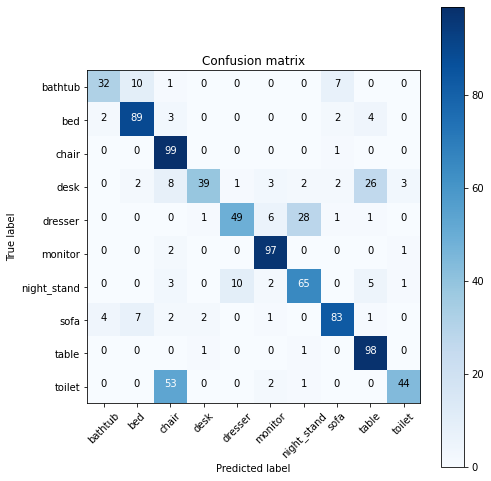

In [173]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_vn2, list(classes.keys()), normalize=False)

Normalized confusion matrix


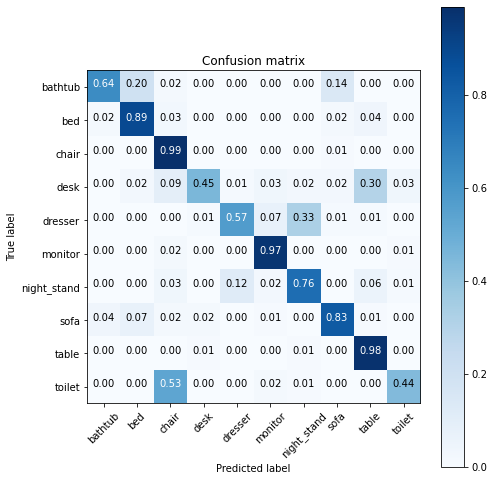

In [174]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_vn2, list(classes.keys()), normalize=True)

## 4.3 Third order Momenet with Vertex Normals

In [96]:
momenet_vn3 = model.Momenet()
momenet_vn3.to(device)
optimizer = torch.optim.Adam(momenet_vn3.parameters(), lr=0.001)

### 4.3 (a) Training

In [97]:
def train(model, train_loader, val_loader=None,  epochs=10, save=True):
    momenet_vn3_acc_list = []
    for epoch in range(epochs): 
        momenet_vn3.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            # inputs.shape == [32, 1024, 3]
            outputs, m3x3= momenet_vn3(inputs, channel="vn3")

            loss = pointNet.momenetloss(outputs, labels, m3x3)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 40 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' % (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        momenet_vn3.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __= momenet_vn3(inputs, channel="vn3")
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)
            momenet_vn3_acc_list.append((epoch, val_acc))

        # save the model
        if save:
            torch.save(momenet_vn3.state_dict(), "SavedPath/Momenet_Path10/vn3/save_"+str(epoch)+".pth")

In [98]:
%%time
train(momenet_vn3, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /  125], loss: 2.294
[Epoch: 1, Batch:   20 /  125], loss: 1.937
[Epoch: 1, Batch:   30 /  125], loss: 1.802
[Epoch: 1, Batch:   40 /  125], loss: 1.504
[Epoch: 1, Batch:   50 /  125], loss: 1.482
[Epoch: 1, Batch:   60 /  125], loss: 1.403
[Epoch: 1, Batch:   70 /  125], loss: 1.371
[Epoch: 1, Batch:   80 /  125], loss: 1.303
[Epoch: 1, Batch:   90 /  125], loss: 1.422
[Epoch: 1, Batch:  100 /  125], loss: 1.132
[Epoch: 1, Batch:  110 /  125], loss: 1.090
[Epoch: 1, Batch:  120 /  125], loss: 1.128
Valid accuracy: 38 %
[Epoch: 2, Batch:   10 /  125], loss: 1.016
[Epoch: 2, Batch:   20 /  125], loss: 1.020
[Epoch: 2, Batch:   30 /  125], loss: 0.920
[Epoch: 2, Batch:   40 /  125], loss: 0.959
[Epoch: 2, Batch:   50 /  125], loss: 0.840
[Epoch: 2, Batch:   60 /  125], loss: 0.905
[Epoch: 2, Batch:   70 /  125], loss: 0.780
[Epoch: 2, Batch:   80 /  125], loss: 0.787
[Epoch: 2, Batch:   90 /  125], loss: 0.812
[Epoch: 2, Batch:  100 /  125], loss: 0.825
[Epoch: 2, 

### 4.3 (b) Test

In [102]:
epochs = 10
for epoch in range(epochs):
    momenet_vn3.load_state_dict(torch.load('SavedPath/Momenet_Path10/vn3/save_'+str(epoch)+".pth"))
momenet_vn3.eval();

In [103]:
%%time
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __ = momenet_vn3(inputs, channel="vn3")
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]
CPU times: user 4min 28s, sys: 40.6 s, total: 5min 9s
Wall time: 4min 51s


In [104]:
cm_vn3 = confusion_matrix(all_labels, all_preds);
cm_vn3

array([[45,  1,  0,  0,  0,  0,  0,  4,  0,  0],
       [ 8, 59,  3,  0,  0,  0,  1, 28,  1,  0],
       [ 0,  0, 95,  0,  0,  0,  0,  1,  0,  4],
       [ 0,  0, 13, 34,  2,  3,  0, 13,  6, 15],
       [ 0,  0,  3,  0, 72,  5,  3,  1,  0,  2],
       [ 0,  0,  0,  1,  0, 92,  0,  0,  0,  7],
       [ 0,  0, 26,  0, 34,  0, 15,  4,  1,  6],
       [ 1,  0,  1,  0,  0,  0,  0, 95,  0,  3],
       [ 0,  0, 17,  3,  0,  0,  0,  0, 79,  1],
       [ 0,  0,  2,  0,  0,  1,  0,  1,  0, 96]])

Confusion matrix, without normalization


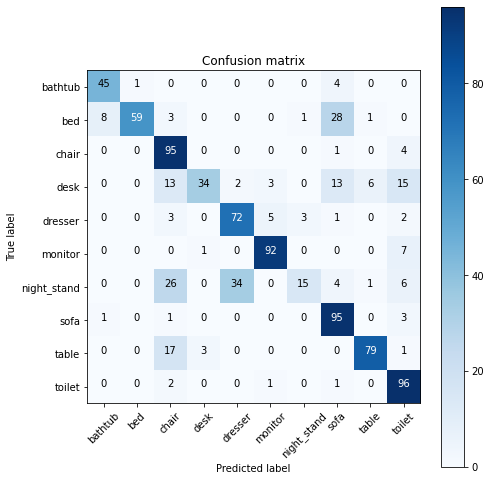

In [169]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_vn3, list(classes.keys()), normalize=False)

Normalized confusion matrix


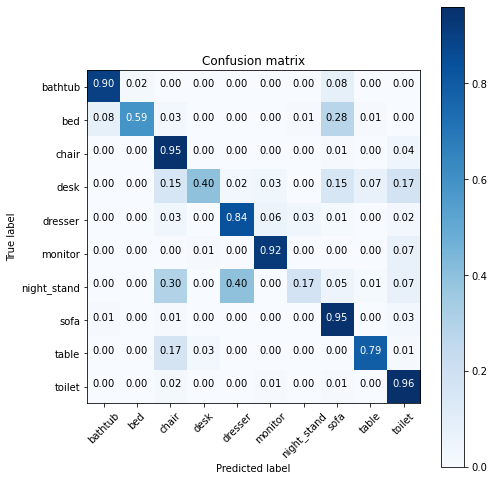

In [170]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_vn3, list(classes.keys()), normalize=True)

# 5.  Harmonic Geometric Pre-lifting

In order to better test the previous models, we define another type of geometric pre-lifting, which is the **harmonic pre-lifting**, which is defined as below:

$sin(x),sin(y),sin(z), cos(x), cos(y), cos(z), sin(2x),sin(2y),sin(2z), cos(2x), cos(2y), cos(2z)$

where we also concat the original $x, y, z$ vectors before the harmonics, and $x, y, z \in [-1, 1]$.

## 5.1 Training

In [112]:
pointnet_hp = model.PointNet()
pointnet_hp.to(device)
optimizer = torch.optim.Adam(pointnet_hp.parameters(), lr=0.001)

In [113]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    pointnet_hp_acc_list = []
    for epoch in range(epochs): 
        pointnet_hp.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet_hp(inputs.transpose(1,2), channel="hp")

            loss = pointNet.pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet_hp.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet_hp(inputs.transpose(1,2), channel="hp")
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)
            pointnet_hp_acc_list.append((epoch, val_acc))

        # save the model
        if save:
            torch.save(pointnet_hp.state_dict(), "SavedPath/PointNet_Path10/hp/save_"+str(epoch)+".pth")

In [114]:
%%time
train(pointnet_hp, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /  125], loss: 1.968
[Epoch: 1, Batch:   20 /  125], loss: 1.446
[Epoch: 1, Batch:   30 /  125], loss: 1.183
[Epoch: 1, Batch:   40 /  125], loss: 1.100
[Epoch: 1, Batch:   50 /  125], loss: 1.021
[Epoch: 1, Batch:   60 /  125], loss: 0.961
[Epoch: 1, Batch:   70 /  125], loss: 0.932
[Epoch: 1, Batch:   80 /  125], loss: 0.940
[Epoch: 1, Batch:   90 /  125], loss: 0.859
[Epoch: 1, Batch:  100 /  125], loss: 0.769
[Epoch: 1, Batch:  110 /  125], loss: 0.833
[Epoch: 1, Batch:  120 /  125], loss: 0.880
Valid accuracy: 52 %
[Epoch: 2, Batch:   10 /  125], loss: 0.854
[Epoch: 2, Batch:   20 /  125], loss: 0.689
[Epoch: 2, Batch:   30 /  125], loss: 0.794
[Epoch: 2, Batch:   40 /  125], loss: 0.652
[Epoch: 2, Batch:   50 /  125], loss: 0.648
[Epoch: 2, Batch:   60 /  125], loss: 0.592
[Epoch: 2, Batch:   70 /  125], loss: 0.697
[Epoch: 2, Batch:   80 /  125], loss: 0.676
[Epoch: 2, Batch:   90 /  125], loss: 0.797
[Epoch: 2, Batch:  100 /  125], loss: 0.645
[Epoch: 2, 

## 5.2 Testing on Harmonic Pre-lifting Model

In [128]:
epochs = 15
for epoch in range(epochs):
    pointnet_hp.load_state_dict(torch.load('SavedPath/PointNet_Path10/hp/save_'+str(epoch)+".pth"))
pointnet_hp.eval();

In [129]:
%%time
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __,_ = pointnet_hp(inputs.transpose(1,2), channel="hp")
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]
CPU times: user 3min 36s, sys: 18.6 s, total: 3min 54s
Wall time: 3min 33s


In [130]:
cm5_hp = confusion_matrix(all_labels, all_preds);
cm5_hp

array([[42,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 96,  2,  0,  0,  0,  0,  1,  1,  0],
       [ 0,  0, 98,  0,  1,  0,  0,  1,  0,  0],
       [ 0,  0,  2, 63,  0,  1,  0,  6, 12,  2],
       [ 0,  0,  0,  2, 33,  4, 19,  0,  1, 27],
       [ 0,  0,  3,  0,  0, 92,  0,  0,  0,  5],
       [ 0,  0,  3,  0, 10,  1, 53,  0, 14,  5],
       [ 0,  0,  2,  0,  0,  0,  0, 98,  0,  0],
       [ 0,  0,  0,  7,  0,  0,  0,  0, 93,  0],
       [ 1,  0,  3,  1,  0,  0,  0,  0,  0, 95]])

In [93]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


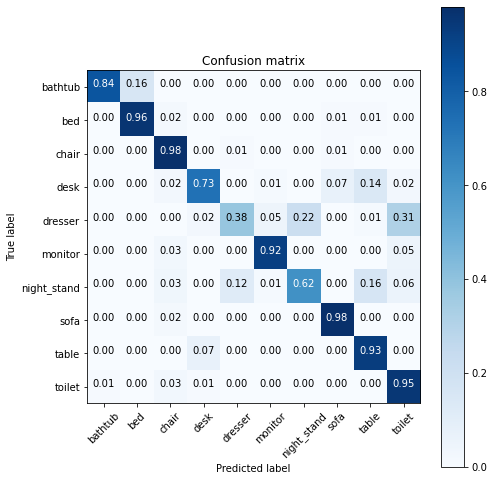

In [175]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm5_hp, list(classes.keys()), normalize=True)